In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".13"

In [2]:
import pandas as pd
from brain import BrainModel
from submodels import factories
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from random import shuffle

from lib.score import (
    fate_corr, score_both_size_norm, shrink_and_align_stats, score_stats_norm
)
from lib.preprocess import *
from lib.callback import (
    cell_number_callback, progenitor_number_callback, neuron_number_callback,
    TargetPopulation, TagNumberCallback, TypeNumberCallback,
)
from lib.sde.grn.grn import GRNMain
from lib.sde.mutate import SparseMutator

from lib.ga.utils import weighted_selection_one, normalize_fitness_values
from lib.utils import pick_best, pick_last
from jf.utils.export import Exporter
from jf.autocompute.jf import O, L
from itertools import product
import jf.models.stringmodel as sm
from lib.analyser import show_curve, show_curve_progenitor
from jf.models.stringmodel import read_model
from lib.utils import normalize_time, align_time
from jf.utils.helper import provide_id

In [3]:
REF = O(
    stats=pd.read_csv("reference/ref_tristate2.csv"),  # ref is a mean
)
SM_GEN = read_model("generation")
_MUTATE_FUNC = SparseMutator()

In [4]:
def individual_generator(id_=-1, cb_init=None):
    sol = Solution(GRNMain(7, 5, 1, generate_funcs=cb_init), id_=id_)
    sol.grn.set_mutable()
    sol.grn.genes[0].init = 1
    for gene in sol.grn.genes:
        gene.noise = max(1, gene.noise)
    sol.grn.compile()
    return sol

In [5]:
class Solution:
    def __init__(self, grn, id_=0, parent=-1):
        self.id = id_
        self.grn = grn
        self.parent = parent
        self.fit = -1
        self.stats = None
        
    def copy(self, id_=0):
        return Solution(self.grn.copy(), id_=id_, parent=self.id)
        
    def mutate(self):
        _MUTATE_FUNC(self.grn)

In [6]:
def score_bb_size(bb, ref, *args, **kwargs):
    stats = bb.stats.copy()
    stats, ref_stats = align_time(stats, ref.stats)
    stats_p, ref_p = normalize_time(stats, ref_stats, "progenitor_pop_size", "progenitor_pop_size")
    stats_infra, ref_n = normalize_time(stats, ref_stats, "infra_pop_size", "neuron_pop_size",
                                    "progenitor_pop_size", "progenitor_pop_size")
    stats_supra, _ = normalize_time(stats, ref_stats, "supra_pop_size", "neuron_pop_size",
                                    "progenitor_pop_size", "progenitor_pop_size")
    last_time_stats, last_time_ref = max(stats.time), max(ref_stats.time)
    time_switch = 64.0
    
    ref_p = ref_p.set_index("time")
    ref_n = ref_n.set_index("time")
    stats_p = stats_p.set_index("time")
    stats_infra = stats_infra.set_index("time")
    stats_supra = stats_supra.set_index("time")
    
    prog_early = stats_p.loc[min(last_time_stats, time_switch)]["progenitor_pop_size"]
    neuron_infra_early = stats_infra.loc[min(last_time_stats, time_switch)]["infra_pop_size"]
    neuron_supra_early = stats_supra.loc[min(last_time_stats, time_switch)]["supra_pop_size"]
    
    prog_late = stats_p.loc[last_time_stats]["progenitor_pop_size"]
    neuron_infra_late = stats_infra.loc[last_time_stats]["infra_pop_size"]
    neuron_supra_late = stats_supra.loc[last_time_stats]["supra_pop_size"]
    
    ref_prog_early = ref_p.loc[time_switch]["progenitor_pop_size"]
    ref_neuron_infra_early = ref_n.loc[time_switch]["neuron_pop_size"]
    ref_neuron_supra_early = 0.0
    
    ref_prog_late = ref_p.loc[last_time_ref]["progenitor_pop_size"]
    ref_neuron_infra_late = ref_neuron_infra_early
    ref_neuron_supra_late = ref_n.loc[last_time_ref]["neuron_pop_size"] - ref_neuron_infra_late
    
    delta_late = (abs(prog_late - ref_prog_late) + abs(neuron_infra_late - ref_neuron_infra_late)
                  + abs(neuron_supra_late - ref_neuron_supra_late))
    delta_early = (abs(prog_early - ref_prog_early) + abs(neuron_infra_early - ref_neuron_infra_early)
                  + abs(neuron_supra_early - ref_neuron_supra_early))

    return 1 / max(1, 10000 - 1 * delta_late - 0.5 * delta_early)

In [7]:
def hook_event_handler(cell_program):
    # prob **2 and **4
    q = np.array(cell_program.quantities)
    if random() < (q[0] / 2)**4:  # missing a reset
        return Action.Divide, GRNCell.Progenitor
    
    if random() < (q[1] / 2)**2 * (1 - q[2] / 2)**2:
        return Action.DiffNeuron, GRNCell.PostMitoticInfra
    
    if random() < (q[2] / 2)**2 * (1 - q[1] / 2)**2:
        return Action.DiffNeuron, GRNCell.PostMitoticSupra
    
    return Action.NoOp, None

In [8]:
def get_bb(prun, grn):
    from submodels.grn_auto_v1 import GRNCell
    ccls = factories["grn_auto1"](grn=grn, hooks=dict(event_handler=hook_event_handler))
    callbacks = dict(
        progenitor_pop_size=progenitor_number_callback,
        whole_pop_size=cell_number_callback,
        neuron_pop_size=neuron_number_callback,
        infra_pop_size=TypeNumberCallback(GRNCell.PostMitoticInfra, TargetPopulation.whole),
        supra_pop_size=TypeNumberCallback(GRNCell.PostMitoticSupra, TargetPopulation.whole),
    )
    bb = BrainModel(time_step=0.25, verbose=False, start_population=prun.size, max_pop_size=5e2,
            cell_cls=ccls, end_time=prun.end_time, start_time=50, silent=True, opti=True,
              run_tissue=True, monitor_callbacks=callbacks)
    return bb

In [9]:
def fitness_multistep(prun, grn, steps):
    total_fitness = 0
    stop = False
    previous_time = None
    bb = get_bb(prun, grn)
    # first step
    for step in steps:
        if not bb.run_until(step.end_time):
            stop = True
        
        score_step = step.score_func(bb, prun.ref, max_step=step.end_time, min_step=step.start_time)
        fitness_step = 1.0 / score_step
        fitness_step = min(fitness_step, step.max_fitness)
        total_fitness += fitness_step
        if fitness_step < step.min_fitness or stop:
            return total_fitness, bb.stats
        else:
            previous_time = step.end_time
            step.passed()
        
    return total_fitness, bb.stats

In [10]:
def fitness_step(prun, grn, step):
    bb = get_bb(prun, grn)
    bb.run_until(step.end_time)
    score_step = step.score_func(bb, prun.ref, max_step=step.end_time, min_step=step.start_time)
    fitness = 1.0 / score_step
        
    return fitness, bb.stats

In [11]:
def do_init(prun):
    return individual_generator(provide_id(), prun.cb_init)

def do_fitness(prun, sol):
    fitness, stats = fitness_step(prun, sol.grn, prun.step)
    return fitness, stats

def do_selection(prun, pop_fit, pop):
    if len(pop) < prun.min_pop:
        return individual_generator(provide_id(), prun.cb_init)
    
    pop_fit = normalize_fitness_values(pop_fit)
    
    return weighted_selection_one(pop, pop_fit, lambda x: individual_generator(x, prun.cb_init), new_fitness=10., id_=provide_id())[0]

def do_mutation(prun, sol):
    sol.mutate()
    return sol

In [12]:
class ObjectiveStep(O):
    start_time = 0
    end_time = 0
    max_fitness = 1e9
    min_fitness = 1
    name = ""
    _passed = False
    
    def reset(self):
        self._passed = False
    
    def passed(self):
        if self._passed:
            return
        print(f"Step {self.name} passed !")
        self._passed = True
    
example_step = ObjectiveStep(name="3", start_time=56, end_time=86, score_func=score_bb_size, min_fitness=0.2)

class ParamRun(O):
    pop_size = 50
    batch_size = 50
    n_gen = 20
    current_gen = 0
    end_time = 86
    ref = REF
    min_pop = 50
    max_pop = 50

def get_prun(size=7, exponent=1):
    prun = ParamRun()
    prun.cb_init = dict()
    prun.size = size
    prun.exponent = exponent
    prun.step = example_step
    return prun

In [13]:
def pick_last_exported(exporter):
    generations = list(filter(SM_GEN.match, exporter.list()))
    if len(generations) == 0:
        return None, 0
    
    last = max(generations, key=lambda x: int(SM_GEN.extract(x).get("generation")))
    b_gen = int(SM_GEN.extract(last).get("generation")) + 1
    exporter.print(f"Found generation {b_gen - 1}", "reload")
    pop = exporter.load(last)
    return pop, b_gen

In [14]:
def main(prun):
    prun.history = dict()
    exporter = Exporter(name=prun.name, copy_stdout=True)
    definition = """
    
    """
    exporter.print(definition, slot="definition")
    best = 0
    
    # setup
    pop, batch_gen = pick_last_exported(exporter)
    
    if batch_gen == prun.n_gen:
        print("Already finished")
        return
    
    if pop is None:
        sol = do_init(prun)
        pop = [sol]
        batch_gen = 0
    else:
        sol = pop[-1]
        
    for i in range(batch_gen * prun.batch_size,
                   prun.n_gen * prun.batch_size):
        fit, stats = do_fitness(prun, sol)
        sol.fit, sol.stats = fit, stats
        
        if i % 100 == 0:
            exporter.print(f"Step {i}")
        if fit > best:
            exporter.print(f"++ Best {fit} for generation {i}")
            best = fit
            
        monitor = sol
        prun.history[i] = monitor
        # exporter(monitor, f"generation_g{generation}")
        
        sub_pop = pop[-prun.max_pop:]
        sol = do_selection(prun, [s.fit for s in sub_pop], sub_pop)
            
        sol = do_mutation(prun, sol)
        pop.append(sol)
        
        if (i + 1) % prun.batch_size == 0:
            print("Saving ...")
            batch_gen = (i + 1) // prun.batch_size
            exporter(pop[-prun.batch_size:], SM_GEN.fill(generation=batch_gen))
        
    return best

In [15]:
callback_init = dict(
    init=lambda: np.random.beta(1.5, 3) * 3,
    b=lambda: np.random.beta(1.5, 3) * 5,
    expr=lambda: 1,
    deg=lambda: 0.1,
    noise=lambda: np.random.beta(1.5, 3) * 1,
    asym=lambda: 5,
)

In [16]:
prun = get_prun()
prun.cb_init = callback_init
prun.name = "test_refacto1"
res = main(prun)

Exporting at output/test_refacto1
[definition] 
    
    
[out] Step 0
[out] ++ Best 9871.135812064384 for generation 0
[out] ++ Best 9871.492954921527 for generation 2
[out] ++ Best 9875.401118186834 for generation 5
[out] ++ Best 9881.625282053854 for generation 13
[out] ++ Best 9882.584465727323 for generation 27
Saving ...
[out] ++ Best 9883.072356215212 for generation 63
[out] ++ Best 9885.594669808956 for generation 68
[out] ++ Best 9885.798751441609 for generation 88
[out] ++ Best 9887.308955523242 for generation 89
Saving ...
[out] Step 100
[out] ++ Best 9889.931404502833 for generation 100
[out] ++ Best 9890.513037155893 for generation 107
[out] ++ Best 9890.962016747731 for generation 115
[out] ++ Best 9891.370180013037 for generation 121
[out] ++ Best 9901.9212004212 for generation 146
Saving ...
[out] ++ Best 9903.38038409467 for generation 151
Saving ...
[out] Step 200
Saving ...
[out] ++ Best 9904.592764378478 for generation 285
Saving ...
[out] Step 300
Saving ...
Saving

In [17]:
exp = Exporter(name=prun.name)

Exporting at output/test_refacto1


In [18]:
sm = read_model("generation")

In [19]:
res = pick_best(exp.load("generation_g10"))
res = pick_best(exp.load(pick_last(exp)))

In [20]:
res.fit

9902.737526951812

In [21]:
# for i in range(5):
#     print(fitness_multistep(prun, res.grn, prun.steps))

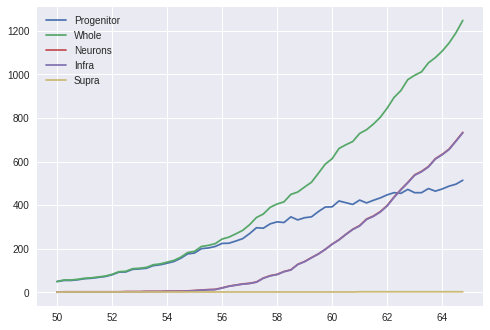

In [22]:
def quick_show(stats):
    plt.plot(stats.time, stats.progenitor_pop_size, label="Progenitor")
    plt.plot(stats.time, stats.whole_pop_size, label="Whole")
    plt.plot(stats.time, stats.neuron_pop_size, label="Neurons")
    plt.plot(stats.time, stats.infra_pop_size, label="Infra")
    plt.plot(stats.time, stats.supra_pop_size, label="Supra")
    plt.legend()
    
quick_show(res.stats)

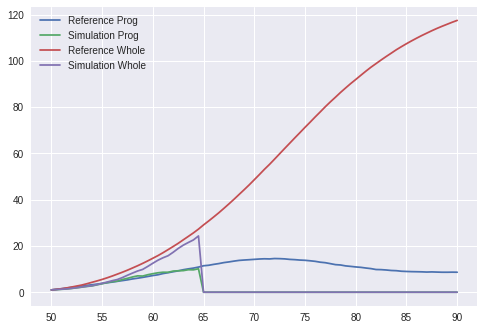

In [23]:
show_curve(res.stats, REF.stats)

In [24]:
for g in sorted(filter(sm.match, exp.list()), key=lambda x: int(sm.extract(x)["generation"])):
    gen = exp.load(g)
    res = pick_best(gen)
    print()
    print(f"======= GENERATION {g} {res.fit} =======")
    print(res.grn)


======= GENERATION generation_g1 9882.584465727323 =======
G> G_0: b=1.01; m=8.14; theta=5.30; init=1.02; noise=1.04; expr=0.91; deg=0.10; asym=5.00; tree=()
G> G_1: b=0.52; m=6.92; theta=7.80; init=1.53; noise=1.00; expr=1.00; deg=0.10; asym=5.00; tree=(0.17x1 AND 0.34x3 AND 0.93x0z)
G> G_2: b=1.67; m=3.45; theta=2.44; init=0.04; noise=1.00; expr=1.00; deg=0.10; asym=5.00; tree=(0.03x0 AND 0.95x4 AND 0.59x2)
G> G_3: b=2.44; m=2.45; theta=6.47; init=1.09; noise=1.00; expr=1.00; deg=0.10; asym=5.00; tree=()
G> G_4: b=4.21; m=5.79; theta=1.71; init=0.81; noise=1.00; expr=1.00; deg=0.10; asym=5.00; tree=()
G> G_5: b=2.99; m=9.13; theta=5.90; init=0.52; noise=1.00; expr=1.00; deg=0.10; asym=5.00; tree=()
G> G_6: b=2.58; m=6.88; theta=9.32; init=0.64; noise=1.07; expr=1.00; deg=0.10; asym=5.00; tree=(0.14x0z)
R> tree=(0.02x1z OR -0.43x4 OR 0.36x6)
R> tree=(-0.59x4 OR -0.75x3)
R> tree=()
R> tree=(0.26x0 OR 0.94x7 OR 0.79x1z)
R> tree=()

======= GENERATION generation_g2 9887.308955523242 ===

In [25]:
GRNMain(7, 5, 1).copy()

G> G_0: b=2.98; m=8.72; theta=6.84; init=1.02; noise=4.08; expr=0.58; deg=1.39; asym=5.35; tree=()
G> G_1: b=0.66; m=8.92; theta=6.75; init=2.70; noise=4.80; expr=0.78; deg=3.62; asym=1.36; tree=(-0.02x2)
G> G_2: b=1.05; m=0.58; theta=4.96; init=2.18; noise=4.70; expr=2.16; deg=7.31; asym=3.90; tree=(0.73x3 AND 0.14x1)
G> G_3: b=2.59; m=2.07; theta=2.59; init=7.71; noise=0.88; expr=1.14; deg=7.81; asym=0.61; tree=(0.43x3 AND 0.35x1 AND 0.93x0)
G> G_4: b=1.97; m=2.80; theta=9.32; init=5.05; noise=0.01; expr=1.00; deg=6.03; asym=6.40; tree=(-0.95x0 AND -0.18x2)
G> G_5: b=1.11; m=1.37; theta=8.72; init=4.00; noise=1.29; expr=1.71; deg=1.39; asym=1.44; tree=()
G> G_6: b=0.76; m=7.46; theta=7.54; init=4.62; noise=1.66; expr=1.88; deg=9.04; asym=3.38; tree=(-0.10x3)
R> tree=(-0.83x7 OR -0.77x3)
R> tree=(-0.68x7 OR -0.70x0 OR 0.59x3)
R> tree=(-0.59x1 OR 0.64x1z OR 0.42x7)
R> tree=(0.85x1z)
R> tree=(0.62x1)